<a href="https://colab.research.google.com/github/ydvdhrj/MakeMore/blob/main/MakeMore2_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making graphs
%matplotlib inline

In [158]:
# read all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [159]:
len(words)

32033

In [160]:
# build the vocabulary of characteres and mapping them from integers
chars = list(sorted(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [161]:
# build the dataset
def build_dataset(words):
  block_size=3 #context length: how many character we need to predict the next character
  X,Y = [],[]

  for w in words:
    # print(w)
    context  = [0]*block_size
    for ch in w+'.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '---->', ch)
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [162]:
len(words)

32033

In [163]:
n1  #training dataset

25626

In [164]:
len(words) - n2  #testing

3204

In [165]:
n2-n1  #dev or validation

3203

In [12]:
C = torch.randn((27,2))

In [27]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [28]:
w1 = torch.randn(6,100)
b1 = torch.randn(100)

In [32]:
# emb @ w1 + b1 -----> this will not work so we have to convert this 32, 3, 2 shape into 32,6 this is like every character of those 3 character contains 2 value

# pytorch provide as cat() function this will contatinate
        # emb[:0:].shape ---> it will be 32,2 similarly all this 3 matrix of 32,2 shape will be concatinate into 32,6 shape
        # syntax of cat is ---> cat(matrix, index along whic u r concatinate)   in our case we concatinate along column i.e  of index 1
# as 3 i.e number of previous character we are usong to predict the next character can be changed so we cant manually put all those indexs
# and to solve this pytorch will have unbind function
# syntax is ---> unbind(provid matrix that wanna unbind, index on which u wanna unbind)

# torch.cat(torch.unbind(emb,1),1).shape

# concatination is actually creating a new tensor which is less memory efficient

# so instead of cat we use view,  view will tell us that in which shape we wanna see the tensor
# tensor is tored as a single dimensional vector in indexes view, stride, metadata help us to get what shape or what tensor we want
# learn more about tensor internals how it s store in database

# syntax of view --->> emb.view(32,6) == emb.view(emb.shape[0],6) == emb.view(-1,6)
# -1 and emb.shape is for general purpose so we dont hard code it
# and when we use -1 pytorch automatically calculate it according to input that what is its dimension

In [34]:
h = torch.tanh(emb.view(-1,6) @ w1 + b1)

In [35]:
h

tensor([[ 0.4137,  0.9817,  0.9760,  ...,  0.3099,  0.2963,  0.6733],
        [ 0.0803,  0.9515,  0.9908,  ..., -0.2412,  0.1501,  0.0394],
        [ 0.3993,  0.7562,  0.9290,  ..., -0.8926, -0.7486,  0.7777],
        ...,
        [ 0.9776,  0.4221, -0.8724,  ...,  0.8593,  0.8252,  0.9831],
        [ 0.5417,  0.9902,  0.9995,  ..., -0.3947, -0.3192, -0.8559],
        [ 0.1902,  0.9774,  0.9875,  ..., -0.9775, -0.9795,  0.5647]])

In [36]:
h.shape

torch.Size([32, 100])

In [37]:
w2 = torch.randn((100,27))
b2 = torch.randn((27))

In [39]:
logits = h @ w2 + b2

In [40]:
counts = logits.exp()

In [41]:
prob = counts/counts.sum(1,keepdims=True)

In [42]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(15.2423)

In [43]:
# ---------------Now made respactable -----------

In [166]:
Xtr.shape,Ytr.shape #dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [217]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10),generator=g)
w1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200,generator=g)
w2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,w1,b1,w2,b2]

In [218]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
# why we use cross_entropy instead of this
#   counts = logits.exp() # counts, equivalent to N
#   probs = counts/counts.sum(1, keepdims=True) # probabilities for next
#   loss = -probs[torch.arange(num),ys].log().mean()

# because corss_entropy will give us
# 1) optimized forward pass
# 2) optimized backward pass
# 3) things will be more numberically stable

In [219]:
for p in parameters:
  p.requires_grad=True

In [220]:
lre = torch.linspace(-3,0,1000)
lre = 10**lre

In [221]:
lri = []
lossi = []
stepi = []

In [222]:


for i in range(200000):

  # mini batch construct
  ix = torch.randint(0,Xtr.shape[0],(32,))

  # forward pass
  emb = C[Xtr[ix]] #(32,3,2)
  h = torch.tanh(emb.view(-1,30) @ w1 + b1)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits,Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lre[i]
  lr = 0.1 if i < 100000 else (0.01 if i < 150000 else 0.0001)
  for p in parameters:
    p.data += -lr*p.grad

  # track stats
  # lri.append(lre[i])
  lossi.append(loss.log10().item())
  stepi.append(i)
# print(loss.item())


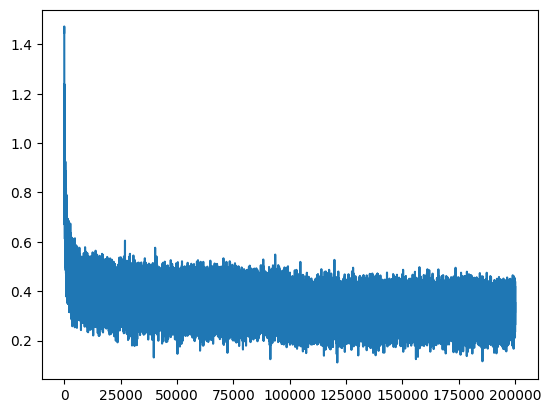

In [223]:
plt.plot(stepi,lossi)

In [224]:
emb = C[Xtr] #(32,3,2)
h = torch.tanh(emb.view(-1,30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.1171, grad_fn=<NllLossBackward0>)

In [ ]:
# 2.1224

In [225]:
emb = C[Xdev] #(32,3,2)
h = torch.tanh(emb.view(-1,30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1488, grad_fn=<NllLossBackward0>)

In [226]:
emb = C[Xte] #(32,3,2)
h = torch.tanh(emb.view(-1,30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,Yte)
loss

tensor(2.1518, grad_fn=<NllLossBackward0>)

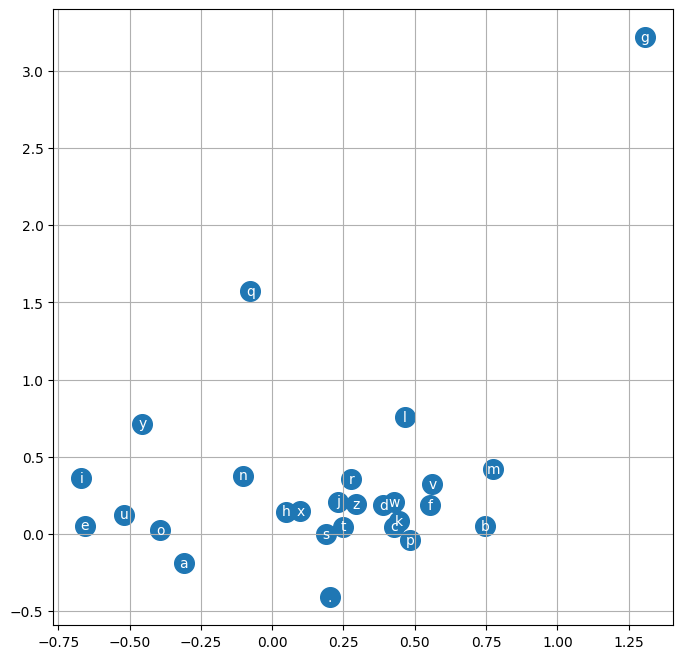

In [189]:
# to visualise when we have 2D embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i], va='center', ha='center', color='white')
plt.grid('minor')

In [227]:
# sample from the model

for _ in range(20):
  out = []
  context = [0]*block_size #initialize with all ...
  while True:
    emb = C[torch.tensor([context])]   #(1,block_size,d)
    h = torch.tanh(emb.view(1,-1) @ w1 + b1)
    logits = h @ w2 +b2
    probs =  F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix==0:
      break
  print(''.join(itos[i] for i in out))

sir.
gialyn.
joca.
gimy.
jelup.
aszipherson.
nick.
romerleser.
leigh.
duliann.
cito.
ceth.
daylen.
nitiel.
anmelo.
detteah.
eutin.
davillayko.
yuh.
aliza.
